In [3]:
import os
import glob
from contextlib import contextmanager
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import torch
@contextmanager
def cwd(path: str) -> None:
    
    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """
    
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def normalize_band(band):
    #band = (band + 1000) / 10000
    #band = band.clip(min=0)
    
    return ((band - band.min()) / (band.max() - band.min()))

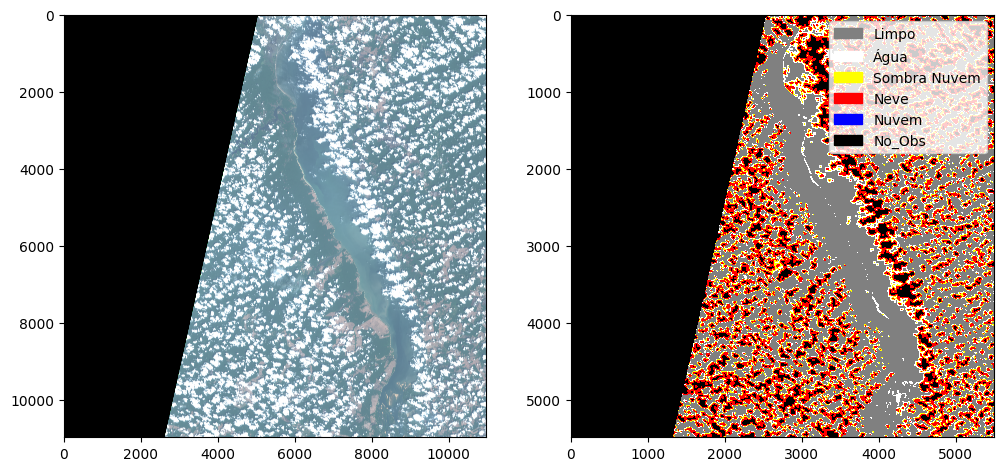

In [4]:
with cwd('../Imagens/awa'):
    imagens = sorted(os.listdir())
    caminho = os.path.join(imagens[0], 'GRANULE')
    with cwd(caminho):
        l1c = os.listdir()[0] # Escolher apenas a primeira imagem
        with cwd(os.path.join(l1c, 'IMG_DATA')):
            bandas = sorted(os.listdir())
            banda_b = rasterio.open([b for b in bandas if 'B02' in b][0]).read(1)  # Blue
            banda_g = rasterio.open([b for b in bandas if 'B03' in b][0]).read(1)  # Green
            banda_r = rasterio.open([b for b in bandas if 'B04' in b][0]).read(1)  # Red
        with cwd(os.path.join(l1c, 'FMASK_DATA')):
            mask = sorted(os.listdir())
            mask = rasterio.open(mask[0]).read()
    
b_r = normalize_band(banda_r)
b_g = normalize_band(banda_g)
b_b = normalize_band(banda_b)

rgb_composite_raw = (np.dstack((b_r, b_g, b_b)) * 3.5).clip(0, 1)
#rgb_composite_raw = np.dstack((b_r, b_g, b_b)).astype(int)
del b_r, b_g, b_b, banda_r, banda_g, banda_b

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(rgb_composite_raw)
plt.subplot(1,2,2)

cmap = mcolors.ListedColormap(['gray', 'white', 'yellow', 'red', 'blue', 'black'])  # Defina as cores
bounds = [0, 1, 2, 3, 4, 255]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
plt.imshow(mask[0], cmap=cmap, norm=norm)
# Criando a legenda manualmente
legend_labels = ['Limpo', 'Água', 'Sombra Nuvem', 'Neve', 'Nuvem', 'No_Obs']
legend_colors = ['gray', 'white', 'yellow', 'red', 'blue', 'black']

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='upper right')

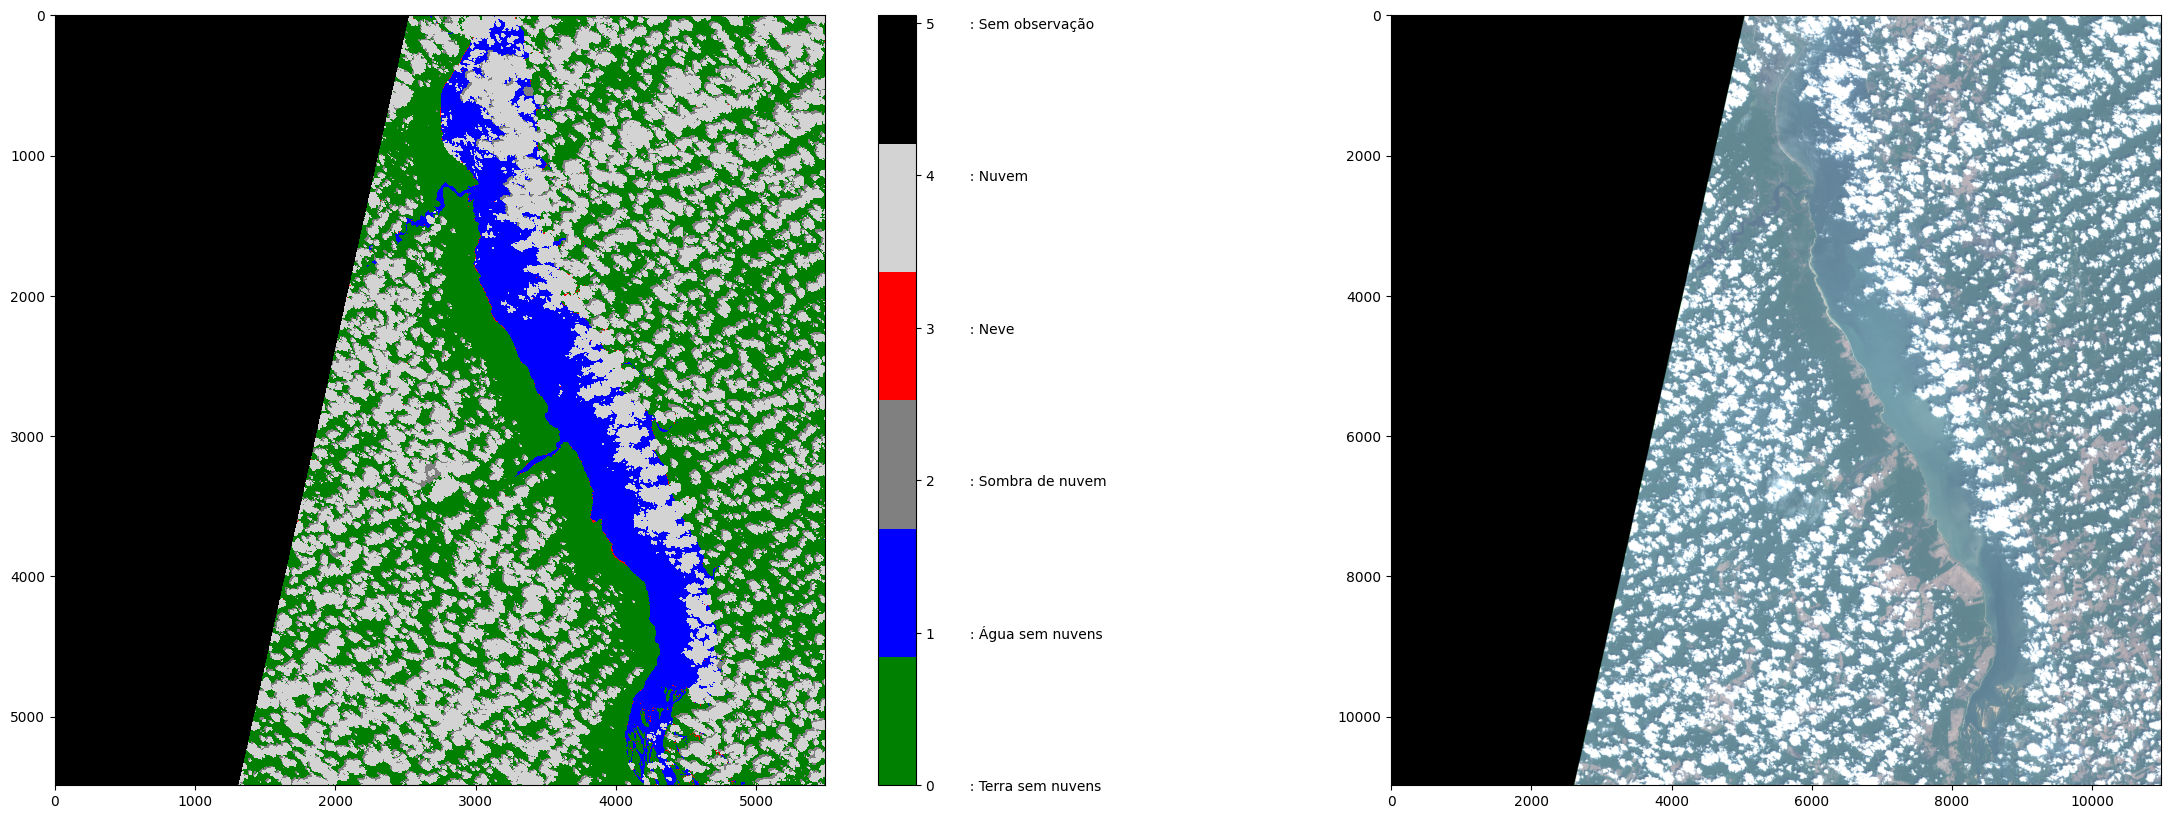

In [15]:
from matplotlib.colors import ListedColormap

colors = {
    0: 'green',        # Terra sem nuvens
    1: 'blue',         # Água sem nuvens
    2: 'gray',         # Sombra de nuvem
    3: 'red',        # Neve
    4: 'lightgray',    # Nuvem
    5: 'black'         # Sem observação
}

labels = [
    'Terra sem nuvens',      # 0
    'Água sem nuvens',       # 1
    'Sombra de nuvem',       # 2
    'Neve',                  # 3
    'Nuvem',                 # 4
    'Sem observação'         # 5
]
mascara_de_classificacao = mask[0]

mascara_de_classificacao[mascara_de_classificacao == 255] = 5 

max_color_len = max(len(color) for color in colors.values())

# Cria uma lista de cores para a visualização usando Matplotlib
cmap = ListedColormap([colors[i] for i in colors])


_, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
im = ax[0].imshow(mascara_de_classificacao, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors)+0.05)
colorbar = plt.colorbar(im, ax=ax[0], ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {labels[x]}")


ax[1].imshow(rgb_composite_raw)   

In [6]:
mascara_de_classificacao = mask
porcentagem_de_terra_sem_nuvem = np.mean(mascara_de_classificacao == 0) * 100
porcentagem_de_agua_sem_nuvem = np.mean(mascara_de_classificacao == 1) * 100
porcentagem_de_sombra_de_nuvem = np.mean(mascara_de_classificacao == 2) * 100
porcentagem_de_neve = np.mean(mascara_de_classificacao == 3) * 100
porcentagem_de_nuvem = np.mean(mascara_de_classificacao == 4) * 100
porcentagem_sem_observacao = np.mean(mascara_de_classificacao == 5) * 100

In [11]:
print(f"""{porcentagem_de_agua_sem_nuvem}\n{porcentagem_de_terra_sem_nuvem}\n{porcentagem_de_neve}\n{porcentagem_de_nuvem}""")

6.032249395323838
28.01255470287093
0.0761576769818282
24.704121751420864
